# Lab | Random forests
## Instructions

- Apply the Random Forest algorithm to predict the TARGET_B. Please note that this column suffers from class imbalance. Fix the class imbalance using upsampling.
- Discuss the model predictions and it's impact in the bussiness scenario. Is the cost of a false positive equals to the cost of the false negative? How much the money the company will not earn because of missclassifications made by the model?
- Sklearn classification models are trained to maximize the accuracy. However, another error metric will be more relevant here. Which one? Please checkout make_scorer alongside with GridSearchCV in order to train the model to maximize the error metric of interest in this case.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, make_scorer, recall_score, classification_report
pd.set_option('display.max_columns', None)

In [2]:
# Loading datasets

categorical = pd.read_csv('files_for_lab/categorical.csv')
numerical = pd.read_csv('files_for_lab/numerical.csv')
target = pd.read_csv('files_for_lab/target.csv')

print(categorical.shape)
print(numerical.shape)
print(target.shape)

(95412, 22)
(95412, 315)
(95412, 2)


In [3]:
# Dropping TARGET_D column as we want to predict TARGET_B

y = target.drop(columns='TARGET_D')
y.value_counts()

TARGET_B
0           90569
1            4843
Name: count, dtype: int64

In [4]:
# Concatenating categorical and numerical

X = pd.concat([categorical, numerical], axis=1)

X.shape

(95412, 337)

In [5]:
# Train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(71559, 337) (23853, 337) (71559, 1) (23853, 1)


In [6]:
# Split X and y into cat/num for preprocessing

X_train_cat = X_train.select_dtypes(object)
X_train_num = X_train.select_dtypes(np.number)

X_test_cat = X_test.select_dtypes(object)
X_test_num = X_test.select_dtypes(np.number)

print(X_train_cat.shape, X_train_num.shape, X_test_cat.shape, X_test_num.shape)

(71559, 7) (71559, 330) (23853, 7) (23853, 330)


In [7]:
# Encoding categorical columns

levels = [list(X_train_cat[col].unique()) for col in X_train_cat.columns]

encoder = OneHotEncoder(drop='first', categories=levels)
categorical_encoded = encoder.fit(X_train_cat)

X_train_cat_encoded = encoder.transform(X_train_cat).toarray()
X_test_cat_encoded = encoder.transform(X_test_cat).toarray()

X_train_cat_encoded_df = pd.DataFrame(X_train_cat_encoded, columns=encoder.get_feature_names_out(), index=X_train.index)
X_test_cat_encoded_df  = pd.DataFrame(X_test_cat_encoded,  columns=encoder.get_feature_names_out(), index=X_test.index)

In [8]:
# Concatenating cat and num

X_train = pd.concat([X_train_cat_encoded_df, X_train_num], axis=1)
X_test = pd.concat([X_test_cat_encoded_df, X_test_num], axis=1)

In [9]:
# Checking class imbalance of train set

y_train.value_counts()

TARGET_B
0           67886
1            3673
Name: count, dtype: int64

In [10]:
# Applying SMOTE to train set in order to address class imbalance

smote = SMOTE(random_state=13)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

y_train_resampled.value_counts()

TARGET_B
0           67886
1           67886
Name: count, dtype: int64

C:\Users\priya\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


The Accuracy for the Random Forest in the TRAIN set is 0.88
The Accuracy for the Random Forest in the TEST  set is 0.83


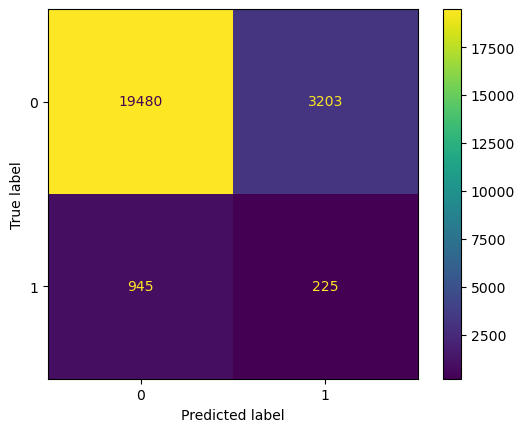

In [11]:
# Training and predicting with Random Forest

rfc = RandomForestClassifier(max_depth=5,
                             min_samples_split=20,
                             min_samples_leaf =20,
                             max_samples=0.8,
                             random_state = 13)

rfc.fit(X_train_resampled, y_train_resampled)

print("The Accuracy for the Random Forest in the TRAIN set is {:.2f}".format(rfc.score(X_train_resampled, y_train_resampled)))
print("The Accuracy for the Random Forest in the TEST  set is {:.2f}".format(rfc.score(X_test, y_test)))

y_pred = rfc.predict(X_test)
cm_test = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm_test, display_labels=rfc.classes_)
disp.plot()

The company would like to minimize false negatives as to not miss potential donors.

In [12]:
def custom_scorer(y_true, y_pred):
    # Use recall for the minority class (class of interest)
    return recall_score(y_true, y_pred, pos_label=1)

# Create the RandomForestClassifier
clf = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=13)

# Define the parameter grid for GridSearchCV
param_grid = {
    'min_samples_split': [5, 10],
    'min_samples_leaf': [5, 10]
}

# Set up GridSearchCV with custom scoring
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring=make_scorer(custom_scorer),
    cv=5,  # Number of cross-validation folds
    verbose=1
)

# Fit the model with GridSearchCV
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


C:\Users\priya\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\priya\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\priya\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\priya\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

In [13]:
grid_search.best_params_

{'min_samples_leaf': 5, 'min_samples_split': 5}

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.84      0.89     22683
           1       0.07      0.22      0.10      1170

    accuracy                           0.81     23853
   macro avg       0.51      0.53      0.50     23853
weighted avg       0.91      0.81      0.85     23853



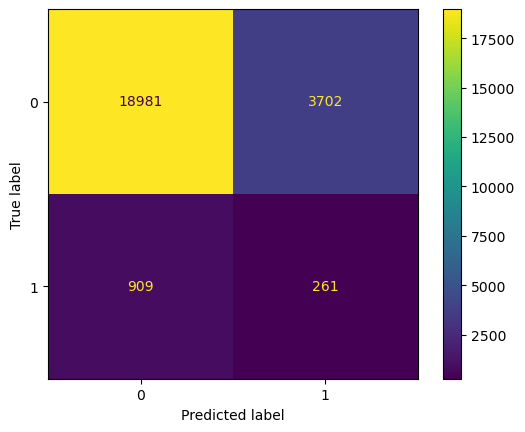

In [14]:
y_pred = best_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

cm_test = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm_test, display_labels=best_model.classes_)
disp.plot()